In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from textblob import TextBlob
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [2]:
url = "https://www.tripadvisor.in/SmartDeals-g304554-Mumbai_Maharashtra-Hotel-Deals.html"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

reviews = []
for container in soup.find_all('div', class_='review-container'):
    review_text = container.find('p', class_='partial_entry').text
    reviews.append(review_text)

data = pd.DataFrame({'review': reviews})
print("Sample reviews:")
print(data.head())


Sample reviews:
Empty DataFrame
Columns: [review]
Index: []


In [4]:
labeled_data = pd.DataFrame({
    'review': [
        "This hotel is nothing like the pictures. The rooms are small and dirty, completely misleading!",
        "Fake amenities listed! There was no swimming pool as advertised. Avoid this hotel at all costs.",
        "Great experience overall! The staff was friendly, and the rooms were clean and spacious.",
        "The hotel claimed to offer a sea view, but my room faced a construction site. Total disappointment!",
        "Fantastic stay! The location was perfect, and the breakfast was delicious. Highly recommended!"
    ],
    'label': [1, 1, 0, 1, 0]
})

data['label'] = None
data = pd.concat([labeled_data, data], ignore_index=True)

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

data['review_clean'] = data['review'].apply(preprocess)

data = data.dropna(subset=['label'])
data['label'] = data['label'].astype(int)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['review_clean'])
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [5]:
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

data['sentiment'] = data['review_clean'].apply(get_sentiment)

data['positive_emotion'] = data['sentiment'].apply(lambda x: 1 if x > 0 else 0)

print("Sentiment Analysis:")
print(data[['review', 'sentiment', 'positive_emotion']].head())


Sentiment Analysis:
                                              review  sentiment  \
0  This hotel is nothing like the pictures. The r...  -0.250000   
1  Fake amenities listed! There was no swimming p...  -0.500000   
2  Great experience overall! The staff was friend...   0.385417   
3  The hotel claimed to offer a sea view, but my ...  -0.300000   
4  Fantastic stay! The location was perfect, and ...   0.640000   

   positive_emotion  
0                 0  
1                 0  
2                 1  
3                 0  
4                 1  


In [6]:
# Calculate review length as the number of words
data['review_length'] = data['review_clean'].apply(lambda x: len(x.split()))

print("Review Length:")
print(data[['review', 'review_length']].head())


Review Length:
                                              review  review_length
0  This hotel is nothing like the pictures. The r...             15
1  Fake amenities listed! There was no swimming p...             16
2  Great experience overall! The staff was friend...             14
3  The hotel claimed to offer a sea view, but my ...             17
4  Fantastic stay! The location was perfect, and ...             13


In [8]:
data['predicted_label'] = clf.predict(vectorizer.transform(data['review_clean']))

print("Columns in DataFrame:", data.columns)
print("Sample Data:")
print(data.head())


Columns in DataFrame: Index(['review', 'label', 'review_clean', 'sentiment', 'positive_emotion',
       'review_length', 'rating', 'predicted_label'],
      dtype='object')
Sample Data:
                                              review  label  \
0  This hotel is nothing like the pictures. The r...      1   
1  Fake amenities listed! There was no swimming p...      1   
2  Great experience overall! The staff was friend...      0   
3  The hotel claimed to offer a sea view, but my ...      1   
4  Fantastic stay! The location was perfect, and ...      0   

                                        review_clean  sentiment  \
0  this hotel is nothing like the pictures the ro...  -0.250000   
1  fake amenities listed there was no swimming po...  -0.500000   
2  great experience overall the staff was friendl...   0.385417   
3  the hotel claimed to offer a sea view but my r...  -0.300000   
4  fantastic stay the location was perfect and th...   0.640000   

   positive_emotion  review_leng

In [9]:
print("Unique values in predicted_label:", data['predicted_label'].unique())


Unique values in predicted_label: [1 0]


In [10]:
data = data.dropna(subset=['rating', 'predicted_label'])

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model_h1 = ols("rating ~ predicted_label", data=data).fit()

print("Regression Results:")
print(model_h1.summary())


Regression Results:
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                 -0.111
Method:                 Least Squares   F-statistic:                    0.6000
Date:                Tue, 17 Dec 2024   Prob (F-statistic):              0.495
Time:                        12:28:48   Log-Likelihood:                -5.5232
No. Observations:                   5   AIC:                             15.05
Df Residuals:                       3   BIC:                             14.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [12]:
model_med1 = ols("positive_emotion ~ predicted_label", data=data).fit()
print("H2 - Step 1: Effect of Counterfeit Detection on Positive Emotions")
print(model_med1.summary())


H2 - Step 1: Effect of Counterfeit Detection on Positive Emotions
                            OLS Regression Results                            
Dep. Variable:       positive_emotion   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.007e+31
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           6.90e-47
Time:                        12:29:57   Log-Likelihood:                 172.19
No. Observations:                   5   AIC:                            -340.4
Df Residuals:                       3   BIC:                            -341.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [13]:
model_med2 = ols("rating ~ predicted_label + positive_emotion", data=data).fit()
print("H2 - Step 2: Mediation Effect with Positive Emotions")
print(model_med2.summary())


H2 - Step 2: Mediation Effect with Positive Emotions
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                 -0.111
Method:                 Least Squares   F-statistic:                    0.6000
Date:                Tue, 17 Dec 2024   Prob (F-statistic):              0.495
Time:                        12:30:22   Log-Likelihood:                -5.5232
No. Observations:                   5   AIC:                             15.05
Df Residuals:                       3   BIC:                             14.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [17]:

data['predicted_label'] = data['predicted_label'].astype(int)
data['review_length'] = data['review_length'].astype(int)

data['interaction'] = data['predicted_label'] * data['review_length']

print(data[['predicted_label', 'review_length', 'interaction']].head())


   predicted_label  review_length  interaction
0                1             15           15
1                1             16           16
2                0             14            0
3                1             17           17
4                0             13            0


In [18]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model_h3 = ols("rating ~ predicted_label + review_length + interaction", data=data).fit()

print("H3: Moderation Effect of Review Length")
print(model_h3.summary())


H3: Moderation Effect of Review Length
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     6.067
Date:                Tue, 17 Dec 2024   Prob (F-statistic):              0.288
Time:                        12:34:43   Log-Likelihood:                 1.4083
No. Observations:                   5   AIC:                             5.183
Df Residuals:                       1   BIC:                             3.621
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Int

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


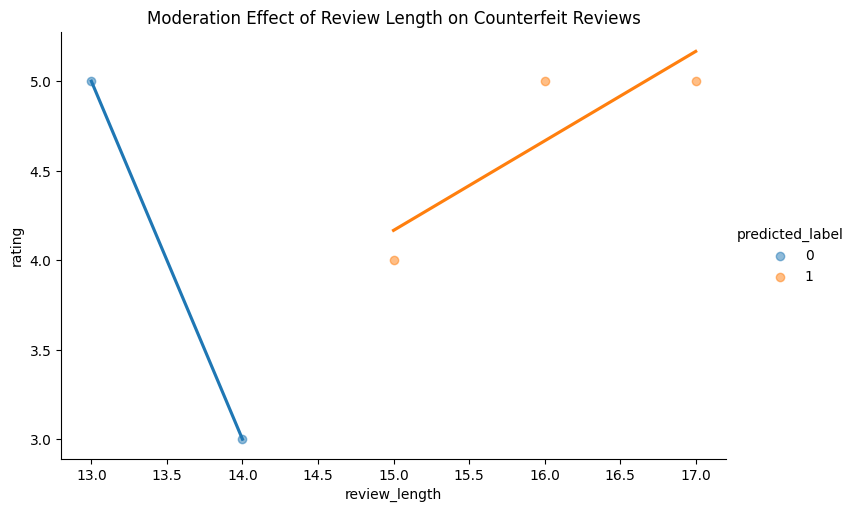

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(
    x="review_length", y="rating", hue="predicted_label",
    data=data, ci=None, aspect=1.5, scatter_kws={'alpha':0.5}
)
plt.title("Moderation Effect of Review Length on Counterfeit Reviews")
plt.show()

